# **M.E.S.S.I:**

*Measurment and Extraction with Sextractor on Surveys Images*

The following scheme summarizes the five steps performed by the script

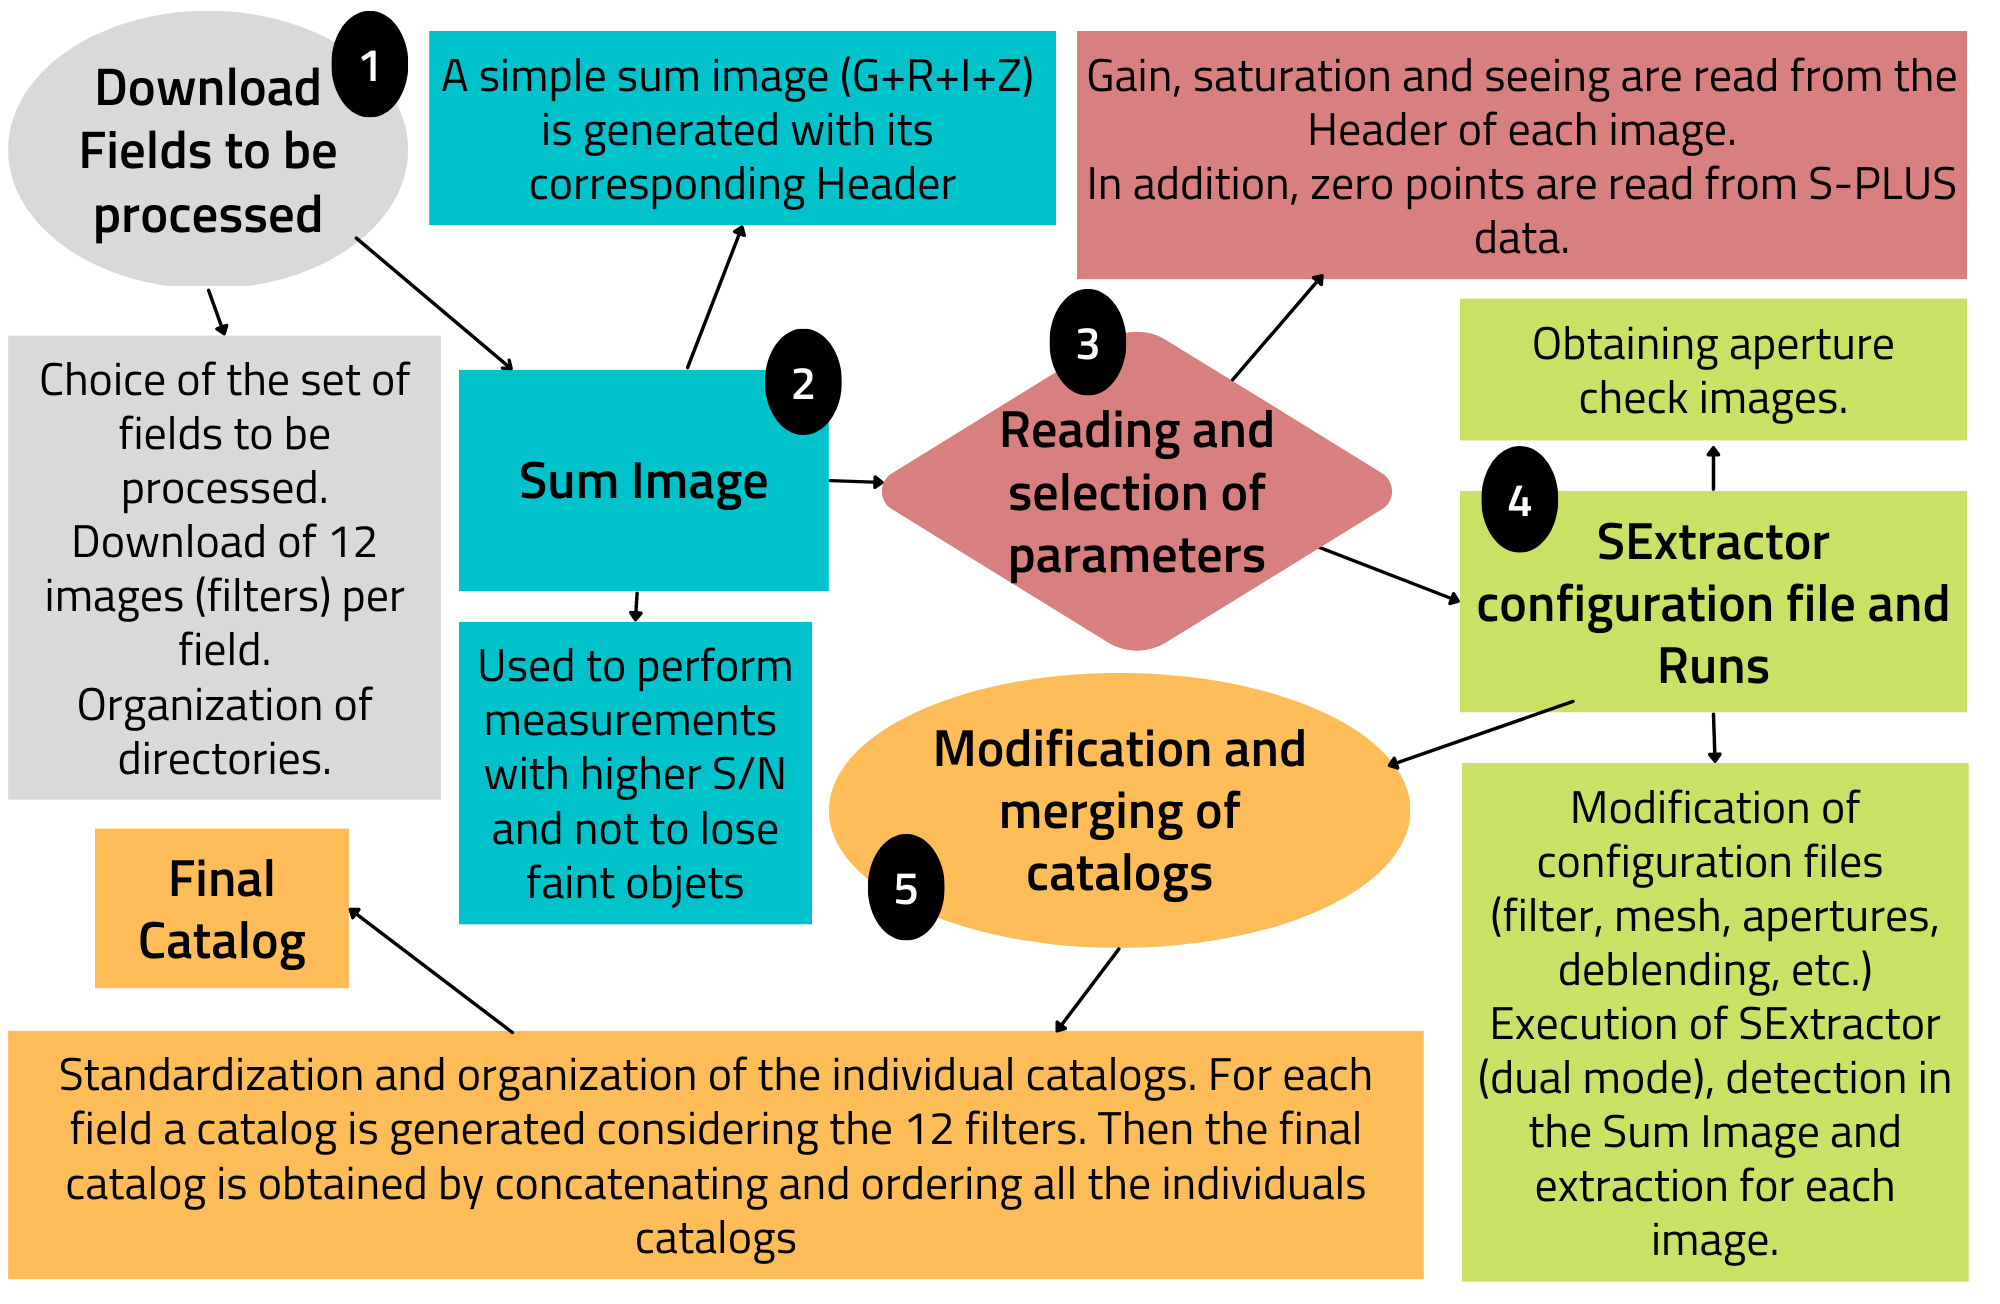

The necessary packages for all the code are imported.

In [ ]:
import splusdata
from astropy.io import fits
import os
import getpass
import shutil
import subprocess
import csv
import re
import pandas as pd
from astropy.table import Table
from functools import reduce

## ***STEP 1: Download fields to be used***

The user must log in to splus.cloud.

In [ ]:
username = input(prompt="Login: ")
password = input("Password: ")
conn = splusdata.connect(username, password)

The S-PLUS fields to be downloaded are explicitly chosen in list format, an example of how the SPLUS fields are named is: "SPLUS-s24s31", and the filter to be used is also indicated.

In [ ]:
lista_campos = ("SPLUS-s24s31","SPLUS-s24s32")
lista_filtros = ("F378", "F395", "F410", "F430", "F515", "F660", "F861", "U", "G", "R", "I", "Z")

A folder "Fields" is created. For each field a subfolder is created inside "Fields" with the name of the field and inside this last one called "Original Images", in which 12 images are downloaded, one for each filter.

Once an image is obtained, it is checked that the header is the complete one and not the short one. After the review, the image corresponding to a filter is saved and the next one is continued with the next one. Once the 12 images for a certain field have been downloaded, the same process is performed for the next field.

In [ ]:
for campo in lista_campos:
    print("Processing:", campo)
    os.makedirs(f'Campos/{campo}/Imagenes_originales/', exist_ok=True)
    for filtro in lista_filtros:
        print("Processing:", campo, filtro)
        hdu = conn.get_field(campo, filtro)
        hdu.writeto(f"Campos/{campo}/Imagenes_originales/{campo}_{filtro}_swp.fits", overwrite=True)
        hdul1 = fits.open(f"Campos/{campo}/Imagenes_originales/{campo}_{filtro}_swp.fits")
        hdr2 = hdul1[1].header
        #print(hdr2) # Here we review the header
        hdul1_data = fits.getdata(f"Campos/{campo}/Imagenes_originales/{campo}_{filtro}_swp.fits")
        fits.writeto(f"Campos/{campo}/Imagenes_originales/{campo}_{filtro}_swp.fits", data = hdul1_data, header = hdr2, overwrite = True)


## ***STEP 2: Sum Image***

In this step for each field an "Images" folder is created in parallel to "Original Images", the 12 downloaded original images are copied to the new folder, this is done to have a backup. The "os" and "shutil" packages are used to do this.

In [ ]:
for campo in lista_campos:
    print("Processing:", campo)
    filtros_de_cada_campo = os.listdir(f'Campos/{campo}/Imagenes_originales')
    os.makedirs(f'Campos/{campo}/Imagenes/', exist_ok=True)
    for filtro in filtros_de_cada_campo:
        dir_entrada = f'Campos/{campo}/Imagenes_originales/{filtro}'
        shutil.copy(dir_entrada, f'Campos/{campo}/Imagenes/')

Then for each field we read the data (pixel array) of the images corresponding to the filters: "G", "R", "I" and "Z". As we have 4 arrays we can sum them and thus generate a sum image. The sum is a simple unweighted sum, i.e., the 4 filters have the same weight. The same procedure is performed by the S-PLUS collaboration.

To the filter "I", besides reading the data, the header is read, duplicated and the following parameters are modified: FILTER and FILENAME.

This modified header is assigned as header of the sum image. It is saved in parallel to the rest of the 12 filters, that is to say, in the "Images" folder. The same process is performed for all other fields.

The generated sum image will be used to run SExtractor, fulfilling the function of being the measurement image, i.e. the reference from which the extractions for each filter will be made. The main motivation to build a sum image is to be able to increase the signal and try not to lose weak objects at the time of measurement.


In [ ]:
for campo in lista_campos:
    print("Generating sum image of the field:", campo)
    img_i = fits.getdata(f'Campos/{campo}/Imagenes/{campo}_I_swp.fits')
    img_r = fits.getdata(f'Campos/{campo}/Imagenes/{campo}_R_swp.fits')
    img_g = fits.getdata(f'Campos/{campo}/Imagenes/{campo}_G_swp.fits')
    img_z = fits.getdata(f'Campos/{campo}/Imagenes/{campo}_Z_swp.fits')
    suma_filtros = img_i + img_r + img_g + img_z # composite image of the sum of the filters
    hdul1 = fits.open(f'Campos/{campo}/Imagenes/{campo}_I_swp.fits')
    hdr2 = hdul1[0].header # filter header reading I
    hdr2.set('FILTER', 'G+R+I+Z') # change of the filter in the composite image header
    hdr2.set('FILENAME', f'Campos/{campo}/Imagenes/{campo}_suma.fits') # change of the file name in the composite image
    #print("HEADER WILL BE PRINTED", hdr2)
    fits.writeto(f'Campos/{campo}/Imagenes/{campo}_suma.fits', data = suma_filtros, header = hdr2, overwrite = True) # saving of the data plus the header with all modifications


## ***STEP 3: Parameter reading and selection***

Here, the code starts going through one field at a time and within each of them builds a list of the 12 filter images and manages to identify and set aside the sum image. It creates a folder "Catalogs/{run}" parallel to "Images" and "Original Images".

A table with the zero points (ZP) previously downloaded and provided by splus.cloud is read out completely. This table contains a field for each row, and in the columns the ZP corresponding to each filter.

We start going through, within a fixed field, a filter by one. On the one hand, the filter name is read, identified, and assigned the respective zeropoint value linked to the table. On the other hand, the following parameters are subtracted from the header:

SATURATE , GAIN and SEEING_FWHM.

This is done with the intention of making the SExtractor measurement under the values of these parameters with which the image was taken. It is worth mentioning that the 3 parameters vary according to the filter, even if they are images of the same field.

This step and the next one are in the same cell. They share execution.

## ***STEP 4: SExtractor Configuration Files and Runs***

In this step, first of all you choose the configuration file with which SExtractor runs will be performed. The configuration files include information about the parameters that you want to appear in the output catalog, information about parameters to guide the detection and extraction, information about the image (photometry and star/galaxy separation), information to perform the background estimation and finally about the check images.


Once the configuration file is chosen and remembering that we are going through filter by filter within a certain field and that for each field we have identified the sum image. A dual address is generated, a directory that includes both the detection image and the measurement image. The detection image will be the sum image and will be the same for all filters in the field, while the measurement image will vary filter by filter. To run SExtractor from Python we used the "subprocess" package, which interacts with a bash terminal to run SExtractor.


The name to identify the run is chosen, which is assigned to "run".


The output of this run generates a catalog for each filter that is stored in "/Fields/{field}/Catalogs/{run}/cat_{filter}. That is, in this instance, per field there will be 12 catalogs.


In addition, in these STEPS the check images, CHECK_IMAGES, are obtained. For this, a single execution of SExtractor is performed in simple mode, i.e., it is detected and measured on the same image. And the image used to perform this process is the sum image corresponding to each field.


After the execution of SExtractor, it creates a directory "Imagenes_check" in parallel to the "Fields" folder and inside this folder, it moves the check image corresponding to the field to a subfolder "Imagenes_check/{run}". Thus, the check images of all fields are stored differentiated by {run}.



In [ ]:
puntos_cero = open('Archivos_de_Configuracion/iDR4_zero-points.csv', 'r', encoding = "utf8")
puntos_cero_reader = csv.reader(puntos_cero, delimiter = ',')
header = next(puntos_cero)
archivo_configuracion = input(prompt="Enter the name of the configuration file to use:")
dir_entrada_configuracion = f'Archivos_de_Configuracion/{archivo_configuracion}'
run = input(prompt="Enter the name to identify the runs with:")
for campo in lista_campos:
    filtros_de_cada_campo_aux = os.listdir(f'Campos/{campo}/Imagenes')
    filtros_de_cada_campo = list(filter(lambda filtro: (not filtro.count('.fz')) and (not filtro.count('suma')), filtros_de_cada_campo_aux))
    lista_filtro_suma = list(filter(lambda filtro: filtro.count('suma'), filtros_de_cada_campo_aux))
    filtro_suma = lista_filtro_suma[0]
    dir_entrada_suma = f'Campos/{campo}/Imagenes/{filtro_suma}'
    os.makedirs(f"Campos/{campo}/Catalogos/{run}/", exist_ok=True)
    print("Processing:", campo)
    puntos_cero = open('Archivos_de_Configuracion//iDR4_zero-points.csv', 'r', encoding = "utf8")
    puntos_cero_reader = csv.reader(puntos_cero, delimiter = ',')
    header = next(puntos_cero)
    for row in puntos_cero_reader:
            if row[0] == campo:
                for filtro in filtros_de_cada_campo:
                    dir_salida = f'Campos/{campo}/Catalogos/{run}/cat_{filtro}'
                    isExist = os.path.exists(dir_salida)
                    if not isExist:
                        if filtro.count('U_swp.fits'):
                            zeropoint = row[3]
                            print("Campo:", campo, "Filtro:", filtro, "Punto de cero:", zeropoint)
                        elif filtro.count('F378_swp.fits'):
                            zeropoint = row[4]
                            print("Campo:", campo, "Filtro:", filtro, "Punto de cero:", zeropoint)
                        elif filtro.count('F395_swp.fits'):
                            zeropoint = row[5]
                            print("Campo:", campo, "Filtro:", filtro, "Punto de cero:", zeropoint)
                        elif filtro.count('F410_swp.fits'):
                            zeropoint = row[6]
                            print("Campo:", campo, "Filtro:", filtro, "Punto de cero:", zeropoint)
                        elif filtro.count('F430_swp.fits'):
                            zeropoint = row[7]
                            print("Campo:", campo, "Filtro:", filtro, "Punto de cero:", zeropoint)
                        elif filtro.count('G_swp.fits'):
                            zeropoint = row[8]
                            print("Campo:", campo, "Filtro:", filtro, "Punto de cero:", zeropoint)
                        elif filtro.count('F515_swp.fits'):
                            zeropoint = row[9]
                            print("Campo:", campo, "Filtro:", filtro, "Punto de cero:", zeropoint)
                        elif filtro.count('R_swp.fits'):
                            zeropoint = row[10]
                            print("Campo:", campo, "Filtro:", filtro, "Punto de cero:", zeropoint)
                        elif filtro.count('F660_swp.fits'):
                            zeropoint = row[11]
                            print("Campo:", campo, "Filtro:", filtro, "Punto de cero:", zeropoint)
                        elif filtro.count('I_swp.fits'):
                            zeropoint = row[12]
                            print("Campo:", campo, "Filtro:", filtro, "Punto de cero:", zeropoint)
                        elif filtro.count('F861_swp.fits'):
                            zeropoint = row[13]
                            print("Campo:", campo, "Filtro:", filtro, "Punto de cero:", zeropoint)
                        elif filtro.count('Z_swp.fits'):
                            zeropoint = row[14]
                            print("Campo:", campo, "Filtro:", filtro, "Punto de cero:", zeropoint)
                        dir_entrada = f'Campos/{campo}/Imagenes/{filtro}'
                        dir_salida = f'Campos/{campo}/Catalogos/{run}/cat_{filtro}'
                        hdul = fits.open(dir_entrada)
                        hdr = hdul[0].header
                        SATURATE = hdr['SATURATE']
                        GAIN = hdr['GAIN']
                        SEEING_FWHM = hdr['HIERARCH OAJ PRO FWHMSEXT']
                        dir_dual = f'"Campos/{campo}/Imagenes/{filtro_suma}","Campos/{campo}/Imagenes/{filtro}"'
                        print("Generating catalog:", filtro)
                        subprocess.run(["sextractor", dir_dual, "-c", f"{dir_entrada_configuracion}", f"-CATALOG_NAME {dir_salida}", f"-GAIN {GAIN}", f"-SEEING_FWHM {SEEING_FWHM}", f"-SATUR_LEVEL {SATURATE}", f"-MAG_ZEROPOINT {zeropoint}"])
    dir_salida_check_aux = f'{campo}_{run}.fits'
    dir_check = re.sub("SPLUS-","",dir_salida_check_aux)
    print("GENERATING CHECK IMAGE OF:", dir_check)
    subprocess.run(["sextractor", dir_entrada_suma, "-c", f"{dir_entrada_configuracion}", "-CATALOG_NAME", "../cat_2.fits", "-CHECKIMAGE_TYPE", "APERTURES", "-CHECKIMAGE_NAME", f"{dir_check}"])
    os.makedirs(f"Imagenes_check/{run}/", exist_ok=True)
    shutil.move(f"{dir_check}", f"Imagenes_check/{run}/{dir_check}")

## ***STEP 5: Modification and merging of catalogs***

In this instance, the process of standardization, union and merging of the catalogs is performed. We start again going through the catalogs field by field, filter by filter. A directory is created inside the folder "/Fields/{field}/Catalogs/" called "Catalogs_modified" where the 12 catalogs corresponding to their respective filters that were generated in STEP 4 and that are located in "/Fields/{field}/Catalogs/{run}/" are copied.

The following modifications will be made to these copies of the catalogs. On the one hand, all columns that are arrays are displayed. This is the case of: MAG_APER, its errors, FLUX_APER, its errors and also FLUX_RADIUS.

Then to this first modification is added a modification in the name of certain columns. This is done in order, on the one hand, to standardize the names to match the S-PLUS catalogs and, on the other hand, to add the name of the filter explicitly in the columns that differ between catalogs of different filters within the same field.

Where for the first time here the "pandas" package is used to read and modify the catalog as a DataFrame. Again this modified catalog overwrites the previous one.

In [ ]:
for campo in lista_campos:
    print("Processing:",campo)
    lista_catalogos_internos_aux = os.listdir(f'Campos/{campo}/Catalogos/{run}')
    lista_catalogos_internos = list(map(lambda cat: re.sub(".fits","",cat), lista_catalogos_internos_aux))
    os.makedirs(f"Campos/{campo}/Catalogos/Catalogos_modificados/{run}/", exist_ok=True)
    for catalogo in lista_catalogos_internos:
        print("Generating:",catalogo)
        if catalogo.count('U_swp'):
            filtro = "U"
        elif catalogo.count('F378_swp'):
            filtro = "F378"
        elif catalogo.count('F395_swp'):
            filtro = "F395"
        elif catalogo.count('F410_swp'):
            filtro = "F410"
        elif catalogo.count('F430_swp'):
            filtro = "F430"
        elif catalogo.count('G_swp'):
            filtro = "G"
        elif catalogo.count('F515_swp'):
            filtro = "F515"
        elif catalogo.count('R_swp'):
            filtro = "R"
        elif catalogo.count('F660_swp'):
            filtro = "F660"
        elif catalogo.count('I_swp'):
            filtro = "I"
        elif catalogo.count('F861_swp'):
            filtro = "F861"
        elif catalogo.count('Z_swp'):
            filtro = "Z"
        subprocess.run(["stilts", "tcopy", f"Campos/{campo}/Catalogos/{run}/{catalogo}.fits", f"Campos/{campo}/Catalogos/Catalogos_modificados/{run}/{catalogo}.fits", "ifmt=fits", "ofmt=fits"])
        dir_1 = f"Campos/{campo}/Catalogos/Catalogos_modificados/{run}/{catalogo}.fits"
        subprocess.run(["stilts", "tpipe", f'in={dir_1}',"cmd= explodeall", f'out={dir_1}'])
        dat = Table.read(f"Campos/{campo}/Catalogos/Catalogos_modificados/{run}/{catalogo}.fits")
        df = dat.to_pandas()
        df.rename(columns={'ALPHA_J2000':'RA', 'DELTA_J2000':'DEC', 'FLUX_AUTO':f'FLUX_AUTO_{filtro}','FLUXERR_AUTO':f'FLUXERR_AUTO_{filtro}','MAG_AUTO':f'{filtro}_AUTO','MAGERR_AUTO':f'e_{filtro}_AUTO','FLUX_ISO':f'FLUX_ISO_{filtro}','FLUXERR_ISO':f'FLUXERR_ISO_{filtro}','MAG_ISO':f'{filtro}_ISO','MAGERR_ISO':f'e_{filtro}_ISO','FLUX_PETRO':f'FLUX_PETRO_{filtro}','FLUXERR_PETRO':f'FLUXERR_PETRO_{filtro}','MAG_PETRO':f'{filtro}_PETRO','MAGERR_PETRO':f'e_{filtro}_PETRO','MAG_APER_1':f'{filtro}_APER_3','MAG_APER_2':f'{filtro}_APER_6','MAGERR_APER_1':f'e_{filtro}_APER_3','MAGERR_APER_2':f'e_{filtro}_APER_6','FLUX_APER_1':f'FLUX_APER_3_{filtro}','FLUX_APER_2':f'FLUX_APER_6_{filtro}','FLUXERR_APER_1':f'FLUXERR_APER_3_{filtro}','FLUXERR_APER_2':f'FLUXERR_APER_6_{filtro}','FLAGS':f'FLAGS_{filtro}', 'FWHM_IMAGE':f'FWHM_IMAGE_{filtro}', 'FWHM_WORLD':f'FWHM_WORLD_{filtro}', 'ISOAREA_IMAGE':f'ISOAREA_IMAGE_{filtro}', 'ISOAREA_WORLD':f'ISOAREA_WORLD_{filtro}', 'KRON_RADIUS':f'KRON_RADIUS_{filtro}', 'PETRO_RADIUS':f'PETRO_RADIUS_{filtro}', 'FLUX_RADIUS_1':f'FLUX_RADIUS_20_{filtro}', 'FLUX_RADIUS_2':f'FLUX_RADIUS_50_{filtro}', 'FLUX_RADIUS_3':f'FLUX_RADIUS_70_{filtro}', 'FLUX_RADIUS_4':f'FLUX_RADIUS_90_{filtro}', 'FLUX_MAX':f'FLUX_MAX_{filtro}', 'SNR_WIN':f'SNR_WIN_{filtro}', 'MU_THRESHOLD':f'MU_THRESHOLD_{filtro}', 'THRESHOLD':f'THRESHOLD_{filtro}', 'MU_MAX':f'MU_MAX_{filtro}', 'CLASS_STAR':f'CLASS_STAR_{filtro}', 'BACKGROUND':f'BACKGROUND_{filtro}'},inplace=True)
        t = Table.from_pandas(df)
        t.write(f"Campos/{campo}/Catalogos/Catalogos_modificados/{run}/{catalogo}.fits", overwrite=True)

After this process, we proceed to merge all the modified catalogs of the same field into only one catalog per field. To do this, using "pandas" again, a list of the 12 DataFrames corresponding to the 12 modified catalogs to be merged is created. Before merging one of the DataFrames, the information of the first columns is extracted, i.e. the information common to all catalogs, i.e. astrometry and geometry, is separated.

Then, on the list of DataFrames, the merging is performed, under a double matcheo in RA and DEC. The first columns "ID" and "Filter" are added as first columns, sorted according to RA and a specific format is given to the object names in the ID column.

In [ ]:
for campo in lista_campos:
    print("Processing:",campo)
    lista_catalogos_aux = os.listdir(f'Campos/{campo}/Catalogos/Catalogos_modificados/{run}')
    for catalogo in lista_catalogos_aux:
        if catalogo.count('U_swp'):
            filtro_U = catalogo
        elif catalogo.count('F378_swp'):
            filtro_F378 = catalogo
        elif catalogo.count('F395_swp'):
            filtro_F395 = catalogo
        elif catalogo.count('F410_swp'):
            filtro_F410 = catalogo
        elif catalogo.count('F430_swp'):
            filtro_F430 = catalogo
        elif catalogo.count('G_swp'):
            filtro_G = catalogo
        elif catalogo.count('F515_swp'):
            filtro_F515 = catalogo
        elif catalogo.count('R_swp'):
            filtro_R = catalogo
        elif catalogo.count('F660_swp'):
            filtro_F660 = catalogo
        elif catalogo.count('I_swp'):
            filtro_I = catalogo
        elif catalogo.count('F861_swp'):
            filtro_F861 = catalogo
        elif catalogo.count('Z_swp'):
            filtro_Z = catalogo
    lista_catalogos = [filtro_U, filtro_F378, filtro_F395, filtro_F410, filtro_F430, filtro_G, filtro_F515, filtro_R, filtro_F660, filtro_I, filtro_F861, filtro_Z]
    data_frames = []
    df_1_aux = lista_catalogos[0]
    lector = Table.read(f'Campos/{campo}/Catalogos/Catalogos_modificados/{run}/{df_1_aux}')
    df_1 = lector.to_pandas()
    df_1.drop(df_1.iloc[:, 21:-1], inplace=True, axis='columns')
    data_frames.append(df_1)
    for catalogo in lista_catalogos:
        print("Processing:", catalogo)
        lector = Table.read(f'Campos/{campo}/Catalogos/Catalogos_modificados/{run}/{catalogo}')
        df = lector.to_pandas()
        df.drop(df.iloc[:, 0:1], inplace=True, axis='columns')
        df.drop(df.iloc[:, 2:20], inplace=True, axis='columns')
        data_frames.append(df)
    df_merged = reduce(lambda  left,right: pd.merge(left,right, on=['RA','DEC'], how='inner', copy=False), data_frames)
    lista_number = df_merged.NUMBER.to_list()
    df_merged.drop(columns ={'BACKGROUND_U_x'}, inplace=True)
    df_merged.drop(columns ={'NUMBER'}, inplace=True)
    df_merged.rename(columns={'BACKGROUND_U_y':'BACKGROUND_U'},inplace=True)
    df_merged = df_merged.sort_values('RA',ascending=True)
    df_merged.insert(0,"ID",lista_number,True)
    df_merged.insert(1, "Field", f"{campo}", allow_duplicates=False)
    df_merged = df_merged.sort_values('RA',ascending=True)
    for ID in range(len(df_merged.ID)+1):
        df_merged.ID = df_merged.ID.replace({ID: f"iDR4_{run}_{campo}.{str(ID).rjust(5, '0')}"})
    t = Table.from_pandas(df_merged)
    t.write(f'Campos/{campo}/Catalogos/cat_{campo}_12_filtros_{run}.fits', overwrite=True)


The last step before obtaining the final catalog will be to read the master catalogs of each field, transform them into DataFrames and add them one by one to a list of DataFrames. Once this list is built, we proceed to concatenate all the catalogs of all the fields, in order to obtain a single standardized final catalog. This catalog is ordered by ID so that, according to the format given for the IDs, the objects are ordered by blocks of fields. That is, if the final catalog is displayed, it will start with all the objects corresponding to one field, then to another and so on for/with all the fields. For this purpose, the lines to be executed are shown below. In addition, as a matter of memory, under the same procedure, split catalogs are obtained. Often the memory is filled when trying to concatenate the information of all the fields at once.

In [ ]:
os.makedirs(f'Catalogos_finales',  exist_ok=True)
data_frames = []
lista_catalogos_a_concat = []
for campo in lista_campos:
    print("Processing:", campo)
    archivos_campo_aux = os.listdir(f'Campos/{campo}/Catalogos')
    lista_catalogo_campo = list(filter(lambda filtro: filtro.count(f'_{run}.fits'), archivos_campo_aux))
    catalogo_campo_aux = lista_catalogo_campo[0]
    catalogo_campo = f'Campos/{campo}/Catalogos/' + catalogo_campo_aux
    print("Adding:", catalogo_campo)
    lista_catalogos_a_concat.append(catalogo_campo)
    lector = Table.read(catalogo_campo)
    df = lector.to_pandas()
    data_frames.append(df)


print("Performing total concatenation")
df_concat = pd.concat(data_frames)
print("Passed concatenation")
df_concat = df_concat.sort_values('ID',ascending=True)
t = Table.from_pandas(df_concat)
t.write(f'Catalogos_finales/catalogo_final_{run}.fits', overwrite=True)